In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tqdm.notebook as tqdm

from util.expectiles import expectile
from util.gmm import GMM

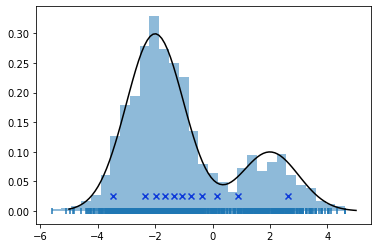

-1.0592616796608918


In [2]:
R = GMM(coeffs=[0.25, 0.75], params=[[2, 1], [-2, 1]])
N = 1000
S = R.rvs(N)
X = np.linspace(-5, 5, 100)
Y = R.pdf(X)
T = np.linspace(0.01, 0.99, 11)
E = expectile(S, T)
plt.hist(S, density=True, alpha=0.5, bins=30)
plt.scatter(S, np.zeros_like(S), marker="|")
plt.plot(X, Y, color="black")
plt.scatter(E, 0.025*np.ones_like(E), marker="x", color="blue")
plt.show()
print(E[5])

In [3]:
class ChainMDP:
    def __init__(self, n=6, r=R):
        self.n = n
        self.r = r
        self.action_space = np.zeros(1)
    def reset(self):
        self.state = 0
        return self.state
    def step(self, action=0):
        self.state += 1
        if self.state == self.n:
            return self.state, self.r.rvs(1)[0], True, {}
        else:
            return self.state, 0, False, {}
    def render(self, end="\r", **kwargs):
        chain = ["(*)" if i == self.state else "( )" for i in range(self.n)]
        chain.append("[*]" if self.n == self.state else "[ ]")
        print("-->"+"-->".join(chain), end=end, **kwargs)
    def close(self):
        print()

env = ChainMDP(6)
done = False
s = env.reset()
env.render()
while not done:
    s, r, done, _ = env.step(0)
    env.render()
env.close()

-->( )-->( )-->( )-->( )-->( )-->( )-->[*]


[0.59049 0.6561  0.729   0.81    0.9     1.     ]


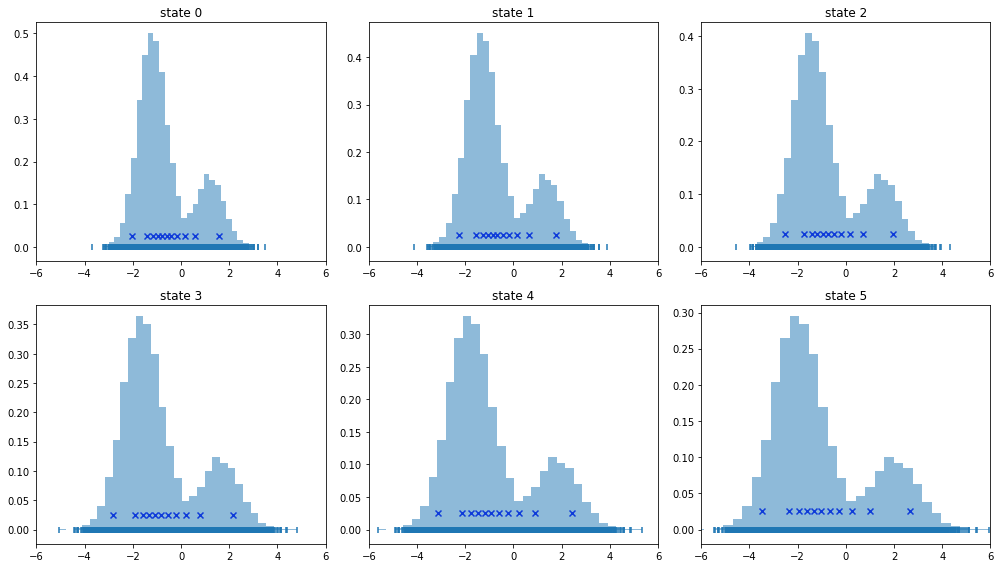

In [359]:
def true_returns(env, episodes=10000, gamma=0.9):
    """Simplified, specially for this MDP. Should do true MC."""
    rewards = np.zeros((episodes, env.n))
    discounts = np.ones(env.n+1)
    discounts[1:] = gamma
    discounts = np.cumprod(discounts)
    discounts = discounts[-2::-1]
    print(discounts)
    for i in tqdm.trange(episodes, unit="eps"):
        env.reset()
        done = False
        while not done:
            _, r, done, _ = env.step(0)
        rewards[i] = r * discounts
    return rewards
G = true_returns(env)

fig, axes = plt.subplots(2, 3, figsize=(14, 8))
for i, ax in enumerate(axes.flat):
    x = G[:, i]
    e = expectile(x, T)
    ax.set_title(f"state {i}")
    ax.hist(x, density=True, alpha=0.5, bins=31)
    ax.scatter(x, np.zeros_like(x), marker="|")
    ax.scatter(e, 0.025*np.ones_like(e), marker="x", color="blue")
    ax.set_xlim([-6, 6])
plt.tight_layout()
plt.show()

In [4]:
def train(env, agent, episodes=10000, render=True, log=False):
    if log: history = [agent.state()]
    for _ in tqdm.trange(episodes, unit="eps"):
        s = env.reset()
        done = False
        if render: env.render()
        while not done:
            a = agent.action(s)
            s_, r, done, _ = env.step(a)
            agent.update(s, a, r, s_, done)
            s = s_
            if render: env.render()
        if log: history.append(agent.state())
    if log: return history

In [86]:
class TradRLAgent:
    def __init__(self, n_actions, n_states, alpha=0.001, gamma=0.9):
        self.n = n_states
        self.m = n_actions
        self.Q = np.zeros((self.n, self.m))
        self.alpha = alpha
        self.gamma = gamma
    def action(self, s):
        return np.argmax(self.Q[s])
    def update(self, s, a, r, s_, terminal):
        if terminal:
            self.Q[s, a] += self.alpha * (r - self.Q[s, a])
        else:
            a_ = self.action(s_)
            self.Q[s, a] += self.alpha * (r + self.gamma*self.Q[s_, a_] - self.Q[s, a])
    def render(self):
        print(self.Q)
    def state(self):
        return self.Q.copy()

trlagent = TradRLAgent(1, 6)
trllog = train(ChainMDP(6), trlagent, episodes=20000, render=False, log=True)

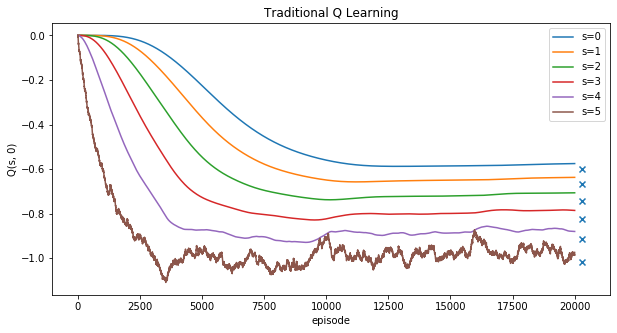

In [360]:
log = np.array(trllog)
plt.figure(figsize=(10, 5))
plt.title("Traditional Q Learning")
for i in range(6):
    plt.plot(log[:, i, 0], label=f"s={i}")
plt.scatter((len(log)+300)*np.ones(6), np.mean(G, axis=0), marker="x")
plt.ylabel("Q(s, 0)")
plt.xlabel("episode")
plt.legend()
plt.show()

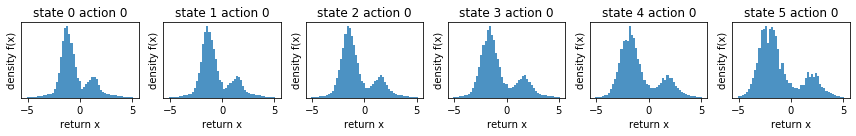

In [87]:
class CDRLAgent:
    def __init__(self, n_actions, n_states, supports, alpha=0.05, gamma=0.9):
        self.n = n_states
        self.m = n_actions
        self.z = supports
        self.k = self.z.size
        self.L = np.zeros((self.n, self.m, self.k)) # logits
        self.dz = np.diff(self.z)
        self.alpha = alpha
        self.gamma = gamma
    def _probs(self, logits):
        probs = np.exp(logits)
        return probs / probs.sum(axis=-1, keepdims=True)
    def action(self, s):
        P = self._probs(self.L[s])
        return np.argmax(P @ self.z)
    def update(self, s, a, r, s_, terminal):
        # follow algorithm 1 in CDRL paper (and EDRL paper)
        # transform:
        if terminal:
            P_ = self._probs(np.zeros_like(self.z))
            w = r * np.ones_like(self.z)
        else:
            a_ = self.action(s_)
            P_ = self._probs(self.L[s_, a_])
            w = r + self.gamma * self.z
        # compute projection:
        Pi = np.zeros_like(self.z)
        l = -1
        for j in range(self.k):
            while l+1 < self.k and self.z[l+1] < w[j]:
                l += 1
            if l < 0:
                Pi[0] += P_[j]
            elif l+1 == self.k:
                Pi[-1] += P_[j]
            elif 0 <= l < self.k-1:
                Pi[l]   += P_[j] * (self.z[l+1] - w[j]) / self.dz[l]
                Pi[l+1] += P_[j] * (w[j] - self.z[l])   / self.dz[l]
            else:
                raise Exception("Algorithm error")
        # step towards target logits according to cross entropy/KL loss
        # (i computed the gradient and this is it!)
        self.L[s, a] -= self.alpha * (self._probs(self.L[s, a]) - Pi)
    def render(self):
        fig, axes = plt.subplots(self.m, self.n, figsize=(2*self.n, 2*self.m))
        P = self._probs(self.L)
        for i in range(self.n):
            for j in range(self.m):
                if self.m > 1:
                    ax = axes[i, j]
                else:
                    ax = axes[i]
                ax.set_title(f"state {i} action {j}")
                ax.set_ylabel("density f(x)")
                ax.set_xlabel("return x")
                ax.bar(self.z, P[i, j], width=self.dz[0], alpha=0.8)
                ax.set_yticks([])
        plt.tight_layout()
        plt.show()
    def state(self):
        return self._probs(self.L)

cdrl_z = np.linspace(-5, 5, 51)
cdrlagent = CDRLAgent(1, 6, supports=cdrl_z)
cdrllog = train(ChainMDP(6), cdrlagent, episodes=20000, render=False, log=True)
cdrlagent.render()

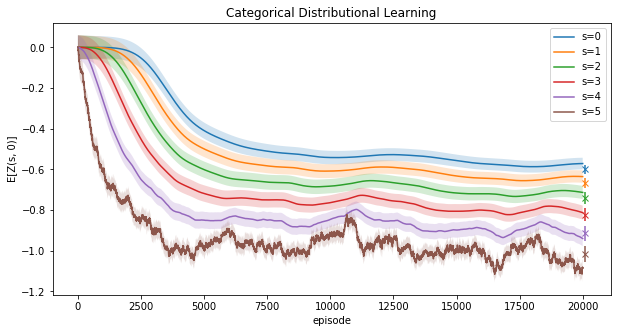

In [361]:
log = np.array(cdrllog)
plt.figure(figsize=(10, 5))
plt.title("Categorical Distributional Learning")
for i in range(6):
    time = np.arange(log.shape[0])
    dist = log[:, i, 0]
    mean = dist @ cdrl_z
    zc = ((cdrl_z - mean[:, np.newaxis])**2)
    sd = np.sqrt((dist[:, np.newaxis] @ zc[:, :, np.newaxis]).squeeze())
    l, = plt.plot(time, mean, label=f"s={i}")
    plt.fill_between(time, mean+0.02*sd, mean-0.02*sd, alpha=0.2, facecolor=l.get_color())
    plt.errorbar(time[-1]+100, np.mean(G[:, i]), yerr=0.02*np.std(G[:, i]), marker="x", color=l.get_color())
plt.ylabel("E[Z(s, 0)]")
plt.xlabel("episode")
plt.legend()
plt.show()

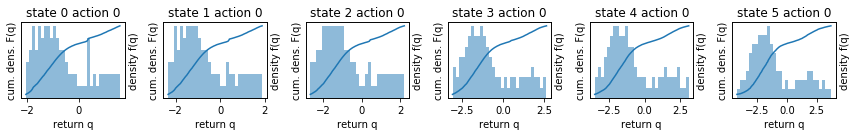

In [90]:
class QDRLAgent:
    def __init__(self, n_actions, n_states, quantile_params, alpha=0.005, gamma=0.9):
        self.n = n_states
        self.m = n_actions
        self.t = quantile_params
        self.k = self.t.size
        self.Q = np.zeros((self.n, self.m, self.k))
        self.Q[:, :] = self.t - 0.5 # initialise to uniform on [-0.5, 0.5]
        self.alpha = alpha
        self.gamma = gamma
    def action(self, s):
        return np.argmax(np.sum(self.Q[s], axis=-1))
    def update(self, s, a, r, s_, terminal):
        # follow algorithm 1 in QDRL paper
        # transform:
        if terminal:            
            T = r * np.ones_like(self.t)
        else:
            a_ = self.action(s_)
            T = r + self.gamma * self.Q[s_, a_]
        # step towards target quantiles according to QR loss
        # NOTE: not using "Quantile Huber Loss" because not doing fn aprx.
        losses_jk = (T[:, None] <= self.Q[s, a]) - self.t
        self.Q[s, a] -= self.alpha / self.k * np.sum(losses_jk, axis=0)
    def render(self):
        fig, axes = plt.subplots(self.m, self.n, figsize=(2*self.n, 2*self.m))
        for i in range(self.n):
            for j in range(self.m):
                if self.m > 1:
                    ax = axes[i, j]
                else:
                    ax = axes[i]
                ax.set_title(f"state {i} action {j}")
                ax.set_ylabel("cum. dens. F(q)")
                ax.set_xlabel("return q")
                ax.plot(self.Q[i, j], self.t)
                ax2 = ax.twinx()
                ax2.hist(self.Q[i, j], density=True, bins=31, alpha=0.5)
                ax2.set_ylabel("density f(q)")
                ax.set_yticks([])
                ax2.set_yticks([])
        plt.tight_layout()
        plt.show()
    def state(self):
        return self.Q.copy()

qdrl_t = np.linspace(0.01, 0.99, 99)
qdrlagent = QDRLAgent(1, 6, quantile_params=qdrl_t)
qdrllog = train(ChainMDP(6), qdrlagent, episodes=20000, render=False, log=True)
qdrlagent.render()

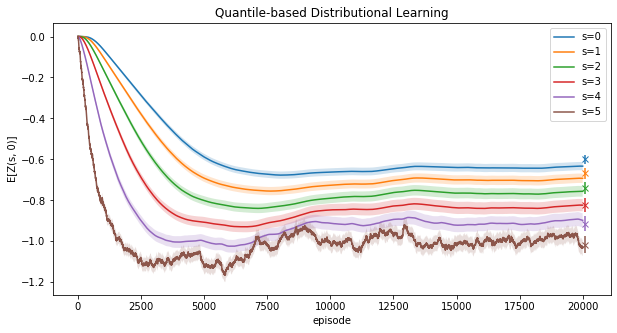

In [362]:
log = np.array(qdrllog)
plt.figure(figsize=(10, 5))
plt.title("Quantile-based Distributional Learning")
for i in range(6):
    time = np.arange(log.shape[0])
    dist = log[:, i, 0]
    mean = np.mean(dist, axis=-1)
    sd = np.std(dist, axis=-1)
    l, = plt.plot(time, mean, label=f"s={i}")
    plt.fill_between(time, mean+0.02*sd, mean-0.02*sd, alpha=0.2, facecolor=l.get_color())
    plt.errorbar(time[-1]+100, np.mean(G[:, i]), yerr=0.02*np.std(G[:, i]), marker="x", color=l.get_color())
plt.ylabel("E[Z(s, 0)]")
plt.xlabel("episode")
plt.legend()
plt.show()

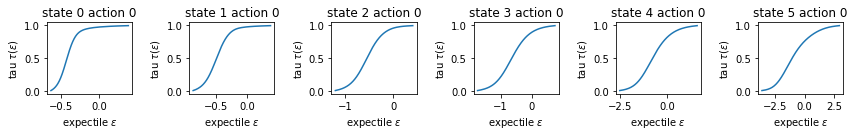

In [212]:
def tauspace(k):
    if not k % 2: raise ValueError("k must be odd.")
    e = 1/(2*k)
    return np.linspace(e, 1-e, k)

class NaiveEDRLAgent:
    def __init__(self, n_actions, n_states, n_expectiles, alpha=0.001, gamma=0.9):
        self.n = n_states
        self.m = n_actions
        self.k = n_expectiles
        self.τ = tauspace(self.k)
        self.μ = self.k // 2
        self.E = np.zeros((self.n, self.m, self.k))
        self.E[:, :] = expectile(np.linspace(-0.5, 0.5, 1000), self.τ)
        self.alpha = alpha
        self.gamma = gamma
    def action(self, s):
        # Select according to preferred expectile id 'μ'
        # e.g. the id of the 0.5 expectile
        return np.argmax(self.E[s, :, self.μ])
    def update(self, s, a, r, s_, terminal):
        # follow 'naive' algorithm from EDRL paper
        # transform
        # (THIS treatment of E[s', a'] (statistics) as samples in a
        # bellman update operation is the 'type error' they refer to)
        if terminal:
            X = r * np.ones_like(self.τ)
        else:
            a_ = self.action(s_)
            X = r + self.gamma * self.E[s_, a_]
        # step towards target expectiles according to ER loss
        rpe = X[:, np.newaxis] - self.E[s, a] # rpe[i, k] = X[i] - E[k]
        scale = np.abs((rpe < 0) - self.τ)    # scale[i, k] = τ[k] if rpe[i, k] > 0 else 1 - τ[k]
        self.E[s, a] += 2 * self.alpha / self.k * np.sum(scale * rpe, axis=0)
    def render(self, imputer=None, bins=51):
        if imputer:
            fig, axes = plt.subplots(self.m*2, self.n, figsize=(2*self.n, 4*self.m))
            for i in range(self.n):
                for j in range(self.m):
                    imputer.fit(self.E[i, j], self.τ)
                    ax1, ax2 = axes[j:j+2, i]
                    ax1.set_title(f"state {i} action {j}")
                    ax1.set_ylabel("tau $\\tau(\\epsilon)$")
                    ax1.set_xlabel("expectile $\\epsilon$")
                    ax1.plot(self.E[i, j], self.τ)
                    ax1.set_yticks([])
                    ax2.set_ylabel("CDF $F(\\epsilon)$")
                    ax2.plot(imputer.ε, imputer.F)
                    ax2.set_yticks([])
                    ax3 = ax2.twinx()
                    ax3.set_ylabel("density $f(\\epsilon)$")
                    ax3.hist(imputer.sample(self.k), bins=bins, density=True, alpha=0.6)
                    ax3.set_yticks([])
        else:
            fig, axes = plt.subplots(self.m, self.n, figsize=(2*self.n, 2*self.m))
            for i in range(self.n):
                for j in range(self.m):
                    if self.m > 1:
                        ax = axes[i, j]
                    else:
                        ax = axes[i]
                    ax.set_title(f"state {i} action {j}")
                    ax.set_ylabel("tau $\\tau(\\epsilon)$")
                    ax.set_xlabel("expectile $\\epsilon$")
                    ax.plot(self.E[i, j], self.τ)
        plt.tight_layout()
        plt.show()
    def state(self):
        return self.E.copy()

nedrlagent = NaiveEDRLAgent(1, 6, 201)
nedrllog = train(ChainMDP(6), nedrlagent, episodes=20000, render=False, log=True)
nedrlagent.render()

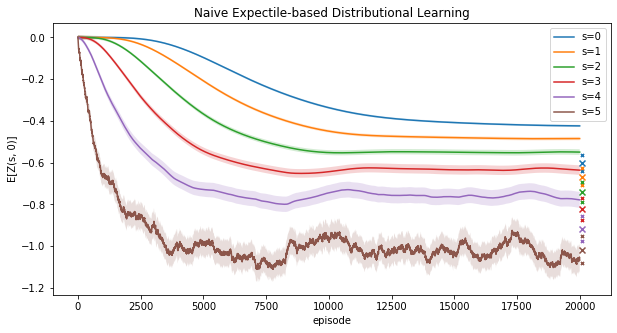

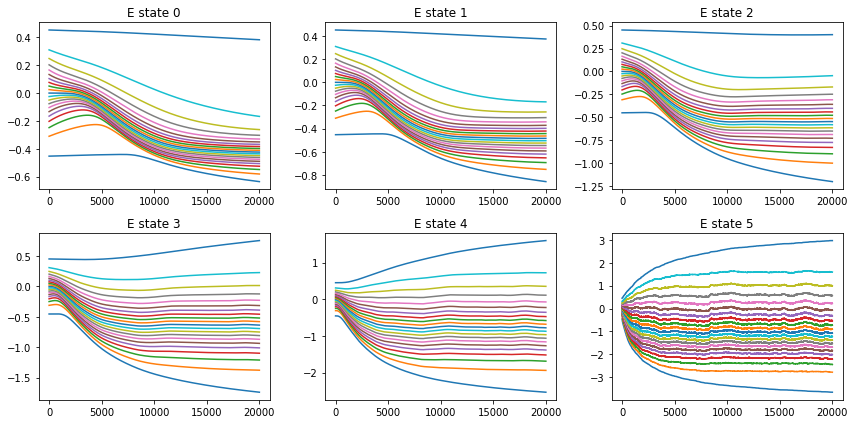

In [363]:
log = np.array(nedrllog)
plt.figure(figsize=(10, 5))
plt.title("Naive Expectile-based Distributional Learning")
half = log.shape[-1]//2
for i in range(6):
    time = np.arange(log.shape[0])
    mean = log[:, i, 0, half]
    mup1 = log[:, i, 0, half + 4]
    mdn1 = log[:, i, 0, half - 4]
    l, = plt.plot(time, mean, label=f"s={i}")
    plt.fill_between(time, mup1, mdn1, alpha=0.2, facecolor=l.get_color())
    plt.scatter(time[-1]+100, expectile(G[:, i], nedrlagent.τ)[half], marker="x", color=l.get_color())
    plt.scatter(time[-1]+100, expectile(G[:, i], nedrlagent.τ)[half+4], s=10, marker="x", color=l.get_color())
    plt.scatter(time[-1]+100, expectile(G[:, i], nedrlagent.τ)[half-4], s=10, marker="x", color=l.get_color())
plt.ylabel("E[Z(s, 0)]")
plt.xlabel("episode")
plt.legend()
plt.show()

fig, axes = plt.subplots(2, 3, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    ax.set_title(f"E state {i}")
    for j in range(0, nedrlagent.k, 10):
        ax.plot(log[:, i, 0, j])
plt.tight_layout()
plt.show()

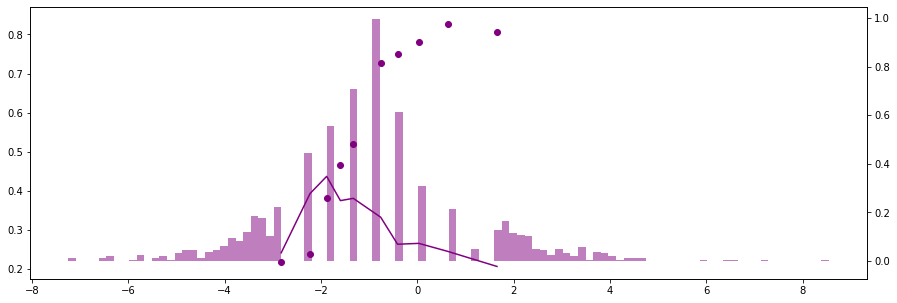

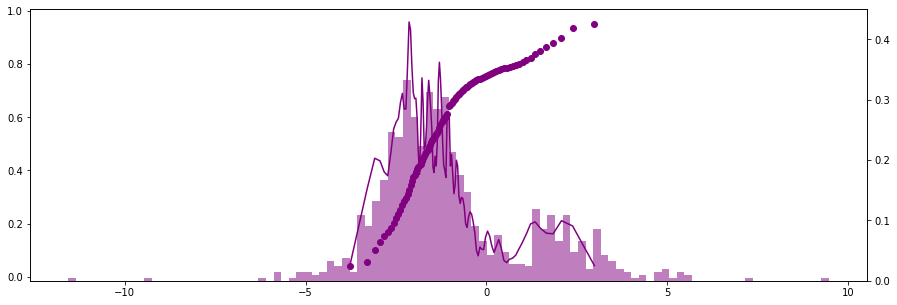

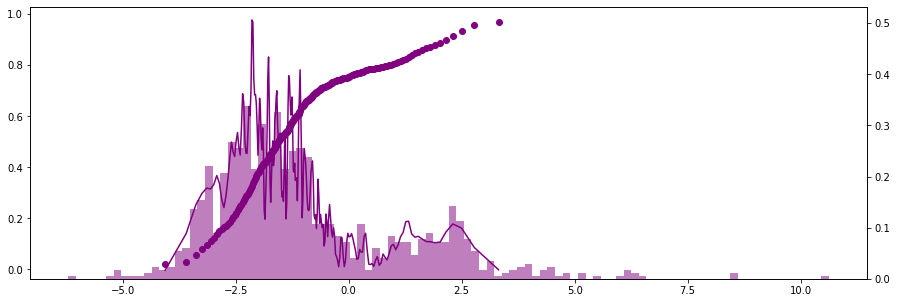

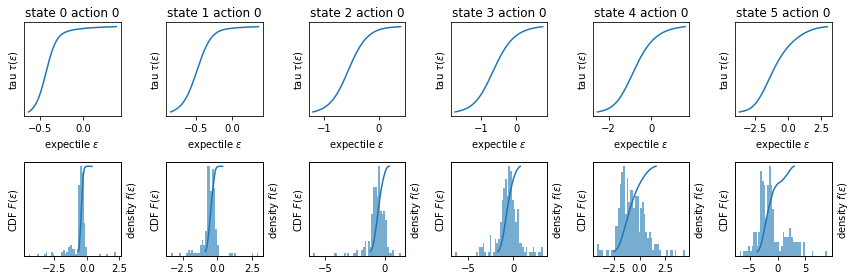

In [339]:
class DirectImputer:
    def __init__(self, sampling_method="smooth-F"):
        self.method = sampling_method
    def fit(self, ε, τ):
        self.ε_ = ε_ = ε
        self.τ_ = τ_ = τ
        self.g_ = g_ = np.gradient(ε_, τ_, edge_order=2)
        
        self.i = i = np.where(np.isclose(τ_, 0.5))
        if not i[0]: raise ValueError("Some tau(s) must be near 0.5.")
        self.μ = μ = np.mean(ε_[i])
        self.τ = τ = np.delete(τ_, i)
        self.ε = ε = np.delete(ε_, i)
        self.g = g = np.delete(g_, i)
        self.F = F = -((ε - μ + τ * g * (1-2*τ)) / (g * (1-2*τ)**2))
        self.f = f = np.gradient(F, ε, edge_order=1)
        return self
    def sample(self, k):
        if self.method == "smooth-ε":
            x = exp_smooth(self.F, self.ε, y, ω=1/self.ε.size**2)
            return x
        elif self.method == "smooth-F":
            ε, h = np.linspace(self.ε.min(), self.ε.max(), self.ε.size, retstep=True)
            F = exp_smooth(self.ε, self.F, ε, ω=h)
        else:
            ε = self.ε
            F = self.F
        y = np.random.random(k)
        i = np.searchsorted(F, y)
        x = ε[np.clip(i, 0, ε.size-1)]
        # handle tails
        lo = np.where(y <  F.min())
        x[lo] = ε.min() - np.random.exponential(size=len(lo[0]))
        hi = np.where(y >= F.max())
        x[hi] = ε.max() + np.random.exponential(size=len(hi[0]))
        return x
    def __repr__(self):
        return "DirectImputer().fit(\n ε={},\n τ={}\n)".format(self.ε_.round(2), self.τ_.round(3))

def exp_smooth(x, y, newx=None, ω=1):
    """
    Given x, y(x), compute y^~(newx), smoothed version, with bandwidth ω
    """
    if newx is None: newx=x
    W = np.exp(-np.square(newx[:, np.newaxis] - x)/ω)
    W /= W.sum(axis=-1, keepdims=True)
    return W @ y
    
def test(k=11):
    τ_ = tauspace(k)
    ε_ = expectile(S, τ_)
    I = DirectImputer().fit(ε_, τ_)
    X = I.sample(1000)
#     newx = np.linspace(I.ε.min(), I.ε.max(), 100)
#     newF = exp_smooth(I.ε, I.F, newx, ω=0.2)
#     x = exp_smooth(I.F, I.ε, np.random.random(1000), ω=0.1/k**2)
    fig = plt.figure(figsize=(15, 5))
    plt.scatter(I.ε, I.F, color="purple")
#     plt.scatter(newx, newF, marker=".")
    plt.twinx()
    plt.plot(I.ε, I.f, color="purple")
    plt.hist(X, density=True, bins=100, alpha=0.5, color="purple")
#     plt.hist(x, density=True, bins=100, alpha=0.5)
    plt.show()

test(k=11)
test(k=99)
test(201)

nedrlagent.render(imputer=DirectImputer())

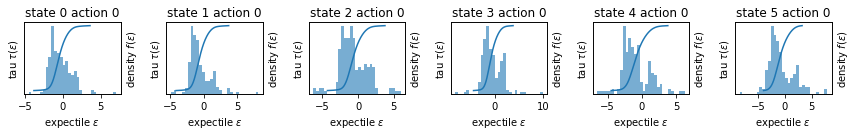

In [393]:
class EDRLAgent:
    def __init__(self, n_actions, n_states, n_expectiles, imputer, alpha=0.001, gamma=0.9):
        self.n = n_states
        self.m = n_actions
        self.k = n_expectiles
        self.τ = tauspace(self.k)
        self.μ = self.k // 2
        self.E = np.zeros((self.n, self.m, self.k))
        self.E[:, :] = expectile(np.linspace(-0.5, 0.5, 1000), self.τ)
        self.Φ = imputer
        self.α = alpha
        self.γ = gamma
        self.lrm = 1/np.sqrt(self.τ * (1-self.τ))
    def action(self, s):
        # Select according to preferred expectile id 'μ'
        # e.g. the id of the 0.5 expectile
        return np.argmax(self.E[s, :, self.μ])
    def update(self, s, a, r, s_, terminal):
        # transform
        if terminal:
            X = r * np.ones_like(self.τ)
        else:
            a_ = self.action(s_)
            X = r + self.γ * self.Φ.fit(self.E[s_, a_], self.τ).sample(self.k)
        # step towards target expectiles according to ER loss
        rpe = X[:, np.newaxis] - self.E[s, a] # rpe[i, k] = X[i] - E[k]
        scale = np.abs((rpe < 0) - self.τ)    # scale[i, k] = τ[k] if rpe[i, k] > 0 else 1 - τ[k]
#         self.E[s, a] += 2 * self.α / self.k * np.sum(scale * rpe, axis=0)
        self.E[s, a] += self.α * self.lrm / self.k * np.sum(scale * rpe, axis=0)
    def render(self):
        fig, axes = plt.subplots(self.m, self.n, figsize=(2*self.n, 2*self.m))
        for i in range(self.n):
            for j in range(self.m):
                if self.m > 1:
                    ax1 = axes[j, i]
                else:
                    ax1 = axes[i]
                ax1.set_title(f"state {i} action {j}")
                ax1.set_ylabel("tau $\\tau(\\epsilon)$")
                ax1.set_xlabel("expectile $\\epsilon$")
                ax1.plot(self.E[i, j], self.τ)
                ax1.set_yticks([])
                ax2 = ax1.twinx()
                ax2.set_ylabel("density $f(\\epsilon)$")
                ax2.hist(self.Φ.fit(self.E[i, j], self.τ).sample(self.k), bins=31, density=True, alpha=0.6)
                ax2.set_yticks([])
        plt.tight_layout()
        plt.show()
    def state(self):
        return self.E.copy()

edrlagent = EDRLAgent(1, 6, 201, imputer=DirectImputer())
edrllog = train(ChainMDP(6), edrlagent, episodes=20000, render=False, log=True)
edrlagent.render()

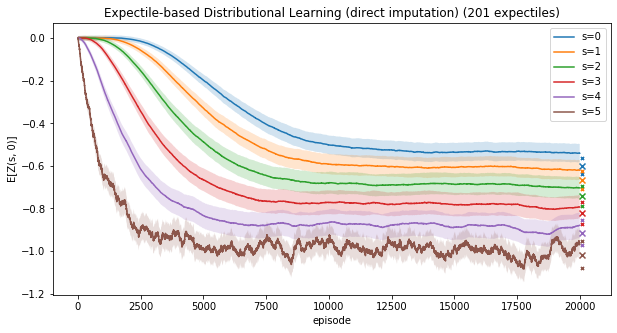

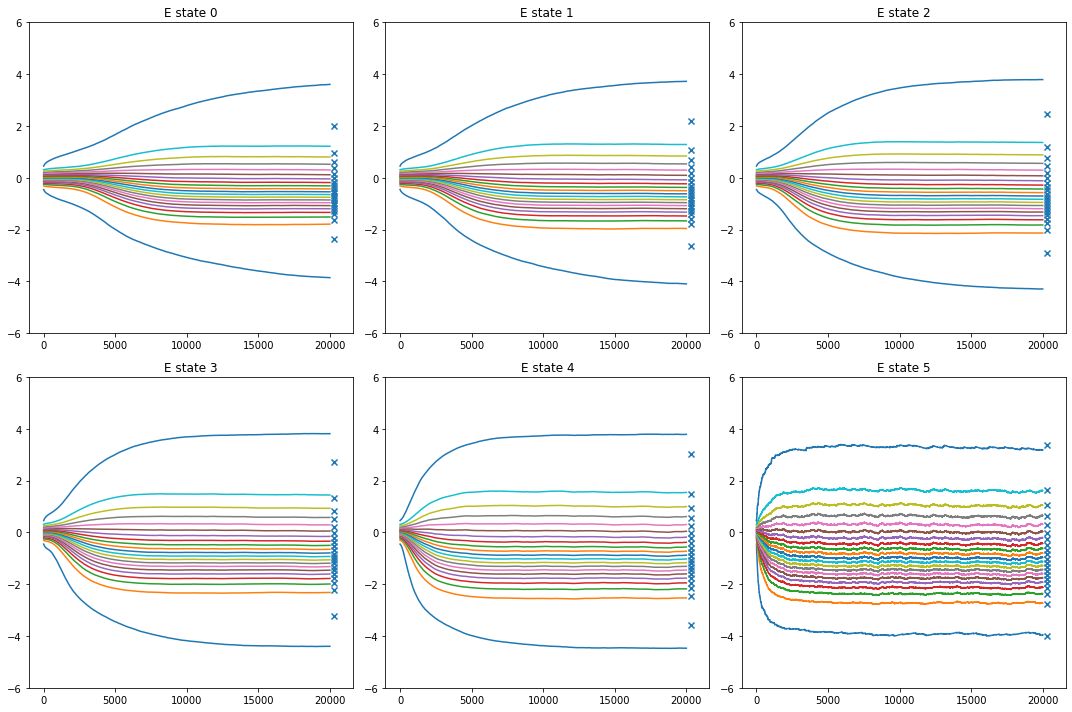

In [397]:
log = np.array(edrllog)
plt.figure(figsize=(10, 5))
plt.title("Expectile-based Distributional Learning (direct imputation) (201 expectiles)")
half = log.shape[-1]//2
for i in range(6):
    time = np.arange(log.shape[0])
    mean = log[:, i, 0, half]
    mup1 = log[:, i, 0, half+4]
    mdn1 = log[:, i, 0, half-4]
    l, = plt.plot(time, mean, label=f"s={i}")
    plt.fill_between(time, mup1, mdn1, alpha=0.2, facecolor=l.get_color())
    plt.scatter(time[-1]+100, expectile(G[:, i], edrlagent.τ)[half], marker="x", color=l.get_color())
    plt.scatter(time[-1]+100, expectile(G[:, i], edrlagent.τ)[half+4], s=10, marker="x", color=l.get_color())
    plt.scatter(time[-1]+100, expectile(G[:, i], edrlagent.τ)[half-4], s=10, marker="x", color=l.get_color())
plt.ylabel("E[Z(s, 0)]")
plt.xlabel("episode")
plt.legend()
plt.show()

k = np.arange(0, log.shape[-1], 10)
τ = edrlagent.τ[(k,)]
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i, ax in enumerate(axes.flat):
    ax.set_title(f"E state {i}")
    for j in k:
        ax.plot(log[:, i, 0, j])
    ax.scatter((len(log)+300)*np.ones(len(k)), expectile(G[:, i], τ), marker="x")
    ax.set_ylim([-6, 6])
plt.tight_layout()
plt.show()

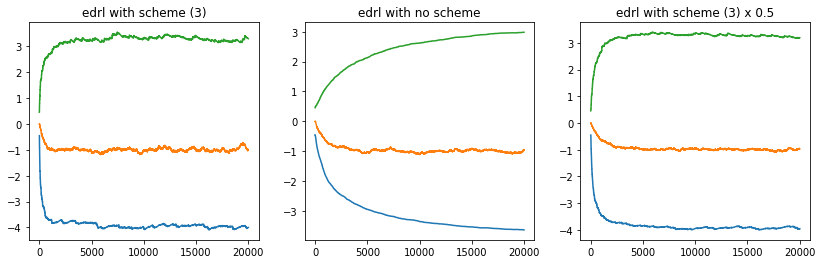

In [399]:
# edrl_lrm_log = log[:, -1, 0, :].T
# edrl_nolrm_log = log[:, -1, 0, :].T
# edrl_halflrm_log = log[:, -1, 0, :].T
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(14, 4))
ax0.set_title("edrl with scheme (3)")
ax1.set_title("edrl with no scheme")
ax2.set_title("edrl with scheme (3) x 0.5")
for tid in [0, 100, 200]:
    ax0.plot(edrl_lrm_log[tid])
    ax1.plot(edrl_nolrm_log[tid])
    ax2.plot(edrl_halflrm_log[tid])
plt.show()

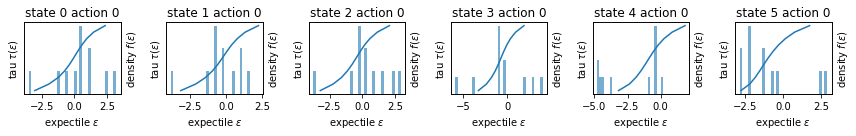

In [344]:
edrlagent11 = EDRLAgent(1, 6, 11, imputer=DirectImputer())
edrllog11 = train(ChainMDP(6), edrlagent11, episodes=20000, render=False, log=True)
edrlagent11.render()

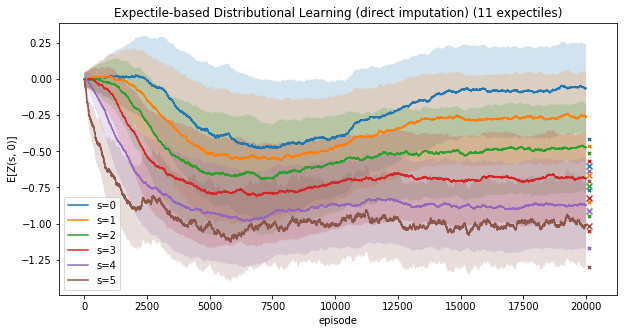

In [388]:
log = np.array(edrllog11)
plt.figure(figsize=(10, 5))
plt.title("Expectile-based Distributional Learning (direct imputation) (11 expectiles)")
half = log.shape[-1]//2
for i in range(6):
    time = np.arange(log.shape[0])
    mean = log[:, i, 0, half]
    mup1 = log[:, i, 0, half+1]
    mdn1 = log[:, i, 0, half-1]
    l, = plt.plot(time, mean, label=f"s={i}")
    plt.fill_between(time, mup1, mdn1, alpha=0.2, facecolor=l.get_color())
    plt.scatter(time[-1]+100, expectile(G[:, i], edrlagent11.τ)[half], marker="x", color=l.get_color())
    plt.scatter(time[-1]+100, expectile(G[:, i], edrlagent11.τ)[half+1], s=10, marker="x", color=l.get_color())
    plt.scatter(time[-1]+100, expectile(G[:, i], edrlagent11.τ)[half-1], s=10, marker="x", color=l.get_color())
plt.ylabel("E[Z(s, 0)]")
plt.xlabel("episode")
plt.legend()
plt.show()

initialising...
optimising...
initialising...
optimising...
initialising...
optimising...
initialising...
optimising...
initialising...
optimising...
initialising...
optimising...


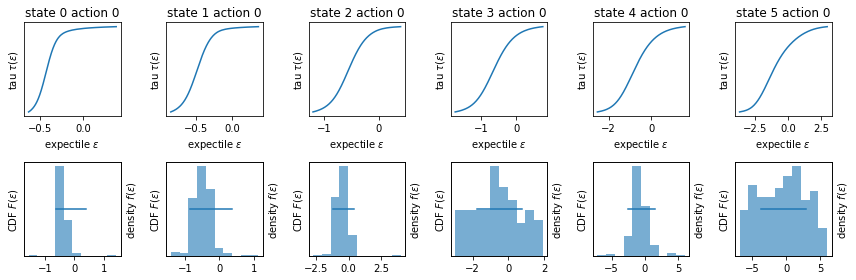

In [333]:
import scipy.optimize as opt

class OptBasedImputer:
    def __init__(self, method='root', start='bestof1000', verbose=False):
        self.method = method
        self.start = start
        self.verbose = verbose
    def fit(self, ε, τ):
        self.τ = τ
        self.ε = ε
        self.F = np.zeros_like(ε)
        return self
    def sample(self, k):
        # initialise
        if self.verbose: print("initialising...")
        lo, hi = self.ε.min(), self.ε.max()
        lo, hi = 1.5*lo - 0.5*hi, 1.5*hi - 0.5*lo # expand initialisation to help optimiser?
        if self.start == 'uniform':
            # initialise as uniform distribution between most extreme expectiles
            z0 = np.linspace(lo, hi, k)
        elif self.start == 'bestof1000':
            # this is implemented for 2020 paper to 'significantly improve optimum found'
            # (note: they also repeat this 10 times)
            zs = np.random.uniform(lo, hi, (1000, k))
            z0 = zs[np.argmin(self._ER_loss(zs))]
        # optimise
        if self.verbose: print("optimising...")
        if self.method=='root':
            if k != len(self.ε):
                raise Exception("Hey! This method requires n=k (number of expectiles)")
            x = opt.root(self._grad_ε_ER_loss, x0=z0).x
        elif self.method=='min':
            # this method is much slower...
            def sum_square_grads(sample):
                return np.sum(self._grad_ε_ER_loss(sample)**2)
            x = opt.minimize(sum_square_grads, x0=z0).x
        return x
    def _ER_loss(self, X):
        n      = X.shape[-1]
        rpe    = X[..., np.newaxis] - self.ε
        scale  = np.abs((rpe < 0) - self.τ)
        losses = np.sum(scale * np.square(rpe) / n, axis=-2)
        return np.sum(losses, axis=-1)
    def _grad_ε_ER_loss(self, X):
        n     = X.size
        rpe   = X[:, np.newaxis] - self.ε  # rpe[i, k] = X[i] - ε[k]
        scale = np.abs((rpe < 0) - self.τ) # scale[i, k] = τ[k] if rpe[i, k] > 0 else 1 - τ[k]
        grads = 2 * np.sum(scale * rpe, axis=0) / n
        return grads

nedrlagent.render(imputer=OptBasedImputer(verbose=True), bins=None)

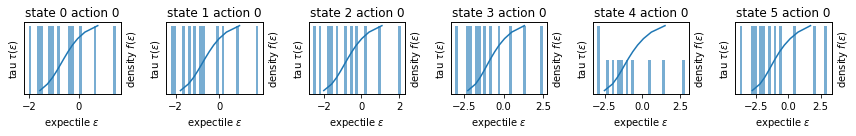

In [334]:
opt_edrlagent = EDRLAgent(1, 6, 11, imputer=OptBasedImputer())
opt_edrllog = train(ChainMDP(6), opt_edrlagent, episodes=20000, render=False, log=True)
opt_edrlagent.render()

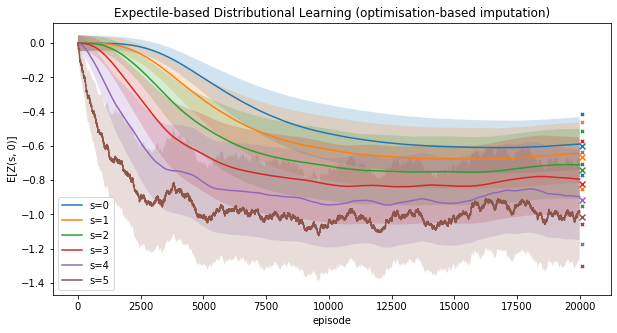

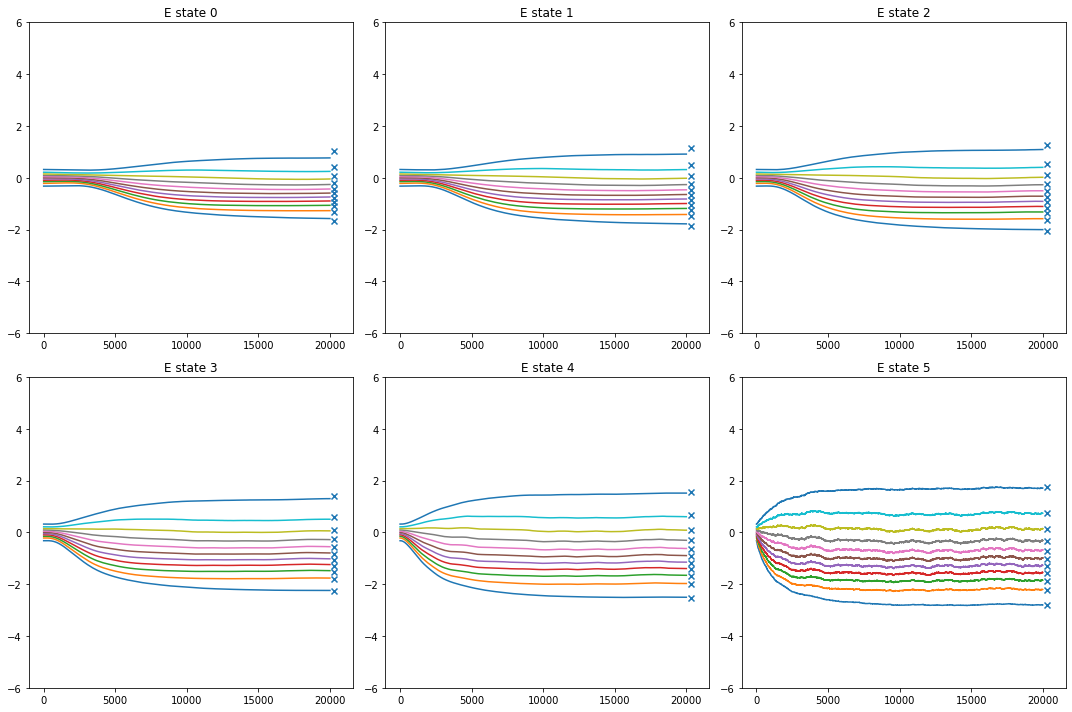

In [368]:
log = np.array(opt_edrllog)
plt.figure(figsize=(10, 5))
plt.title("Expectile-based Distributional Learning (optimisation-based imputation)")
half = opt_edrl_k//2
for i in range(6):
    time = np.arange(log.shape[0])
    mean = log[:, i, 0, half]
    mup1 = log[:, i, 0, half + 1]
    mdn1 = log[:, i, 0, half - 1]
    l, = plt.plot(time, mean, label=f"s={i}")
    plt.fill_between(time, mup1, mdn1, alpha=0.2, facecolor=l.get_color())
    plt.scatter(time[-1]+100, expectile(G[:, i], opt_edrlagent.τ)[half], marker="x", color=l.get_color())
    plt.scatter(time[-1]+100, expectile(G[:, i], opt_edrlagent.τ)[half+1], s=10, marker="x", color=l.get_color())
    plt.scatter(time[-1]+100, expectile(G[:, i], opt_edrlagent.τ)[half-1], s=10, marker="x", color=l.get_color())
plt.ylabel("E[Z(s, 0)]")
plt.xlabel("episode")
plt.legend()
plt.show()

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i, ax in enumerate(axes.flat):
    ax.set_title(f"E state {i}")
    for j in range(opt_edrlagent.k):
        ax.plot(log[:, i, 0, j])
    ax.scatter((len(log)+300)*np.ones(opt_edrlagent.k), expectile(G[:, i], opt_edrlagent.τ), marker="x")
    ax.set_ylim([-6, 6])
plt.tight_layout()
plt.show()

Timing:
 
| method | time (20kEp) | fit |
|---|---|--|
| traditional | 0:10 | mean only |
| cat 51 | 1:11 | :) |
| qdrl 201 | 0:28 | :) |
| naive 201 | 1:01 | biased, tight |
| direct 11 | 1:32 | :( WIP |
| direct 201 | 4:09 | :( WIP |
| opt 11 (best1000, root) | ~20-25m | :) |
| opt 11 (best1000, min) | >2h (est.) | zzz |
    

## TODO:

* The direct imputation method needs more work, it's noticably affecting the results!
    * How to sensibly invert the CDF (to get a sample)? Resolution is limited when there are too few expectiles.
    * How to handle the tails? Using exponential distribution seems to be dragging out the expectiles too much.
* Expectile-based DistRL without imputation (can we solve for the scaled expectiles? the key problem seems to be that they are not scale invariant! but maybe there is a simple correction, for example once we have the CDF...)